# Proyecto final: Sistema de Recomendación de Licitaciones (Preprocesamiento) 📄✨

<br>

<div class="alert alert-block alert-warning">
<b> Integrantes:</b> &nbsp; Daniel Andrade, Gabriel Cubides, Dewith Miramón & Santiago Prado<br>
</div>

<br>

Para el proyecto final decidimos crear un sistema de recomendación de licitaciones, esto con el fin de que  empresas tengan mayores posibilidades de encontrar oportunidades de negocio relevantes.

Para ello construimos un sistema de recomendación híbrido, es decir, una combinación de filtro colaborativo y filtro basado en contenido. Para el contenido usaremos varios atributos de las licitaciones como la cuantía, la entidad, el bien/servicio solicitado, entre otros.

Los datasets se obtuvieron de Datos Abiertos:
[SECOP II - Procesos de Contratación](https://www.datos.gov.co/Gastos-Gubernamentales/SECOP-II-Procesos-de-Contrataci-n/p6dx-8zbt) y
[SECOP II - Proponentes por Proceso](https://www.datos.gov.co/Gastos-Gubernamentales/Proponentes-por-Proceso-SECOP-II/hgi6-6wh3).


<div style="text-align:center">
<img src="https://images.pexels.com/photos/8278870/pexels-photo-8278870.jpeg?cs=srgb&dl=pexels-antoni-shkraba-production-8278870.jpg&fm=jpg" alt="A Man in Black Suit Holding Paper Documents" width="700"/>
</div>
<sup>
Photo by ANTONI SHKRABA production from <a href="https://www.pexels.com/photo/a-man-in-black-suit-holding-paper-documents-8278870/">Pexels</a>
</sup>


<!---
![imagen.png](https://images.pexels.com/photos/8278870/pexels-photo-8278870.jpeg?cs=srgb&dl=pexels-antoni-shkraba-production-8278870.jpg&fm=jpg)
-->



#### Cargue de  librerías

In [ ]:
# Misc
import gc
import re
import textwrap
import pickle

# Data
import scipy 
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

# Visualización 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotx
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

# ML
from sklearn import model_selection

In [ ]:
def clean_values(value, remove_zeros=True):
    if pd.isna(value):
        new_value = np.nan
    else:
        try:
            new_value = np.int64(re.sub('[^0-9]', '', str(value))[:9])
        except Exception:
            new_value = np.nan

    if remove_zeros:
        return new_value if new_value > 0 else np.nan
    else:
        return np.nan

#### Lectura de datos

In [ ]:
%%time
cols_dtypes = {
    'ID del Proceso': 'category',
    'Nit Entidad': 'category',
    'Entidad': 'category',
    'Departamento Entidad': 'category',
    'Nombre del Procedimiento': object,
    'Precio Base': np.float32,
    'Modalidad de Contratacion': 'category',
    'Estado de Apertura del Proceso': 'category',
    'Adjudicado': 'category',
    'Nombre del Proveedor Adjudicado': 'category',
    'Codigo Principal de Categoria': object,
    'NIT del Proveedor Adjudicado': object,
    'Tipo de Contrato': 'category'
}

path = '/datasets/licitana/Data/secop_contratos.csv'
contracts = pd.read_csv(path,
                        usecols=list(cols_dtypes.keys()) + ['Fecha de Publicacion del Proceso'],
                        chunksize=500000,
                        na_values=['No Definido', -1, 'No Adjudicado'],
                        parse_dates=['Fecha de Publicacion del Proceso'],
                        infer_datetime_format=True,
                        low_memory=False, 
                        dtype=cols_dtypes)

contracts_clean = []
for chunk in range(4):
    contracts_chunk = contracts.get_chunk()
    contracts_chunk.dropna(inplace=True, subset=["NIT del Proveedor Adjudicado"])
    contracts_clean.append(contracts_chunk)

contracts = pd.concat(contracts_clean, axis=0)
del contracts_clean

contracts['Nit Entidad'] = contracts['Nit Entidad'].apply(clean_values)
contracts['NIT del Proveedor Adjudicado'] = contracts['NIT del Proveedor Adjudicado'].apply(clean_values)

contracts = contracts[
    pd.to_numeric(
        contracts['NIT del Proveedor Adjudicado'], 
        errors='coerce', 
        downcast='integer'
    ).notnull()
]

contracts['Nit Entidad'] = contracts['Nit Entidad'].astype(
    np.int32, errors='raise')
contracts['NIT del Proveedor Adjudicado'] = contracts['NIT del Proveedor Adjudicado'].astype(
    np.int32, errors='raise')

contracts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210913 entries, 1547 to 1731017
Data columns (total 14 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Entidad                           210913 non-null  object        
 1   Nit Entidad                       210913 non-null  int32         
 2   Departamento Entidad              160834 non-null  category      
 3   ID del Proceso                    210913 non-null  object        
 4   Nombre del Procedimiento          210913 non-null  object        
 5   Fecha de Publicacion del Proceso  210913 non-null  datetime64[ns]
 6   Precio Base                       210913 non-null  float32       
 7   Modalidad de Contratacion         210913 non-null  object        
 8   Adjudicado                        210913 non-null  category      
 9   Nombre del Proveedor Adjudicado   210913 non-null  object        
 10  NIT del Proveedor Adjudicado

In [ ]:
%%time
cols_dtypes = {
    'ID Procedimiento': object,
    'NIT Entidad': object,
    'NIT Proveedor': object,
}

path = '/work/data/01_raw/secop_proponentes.csv'
bidders = pd.read_csv(path,
                      usecols=list(cols_dtypes.keys()),
                      dtype=cols_dtypes,
                      low_memory=False)

bidders['NIT Entidad'] = bidders['NIT Entidad'].apply(clean_values)
bidders['NIT Proveedor'] = bidders['NIT Proveedor'].apply(clean_values)

bidders = bidders[
    pd.to_numeric(
        bidders['NIT Proveedor'], 
        errors='coerce',
        downcast='integer'
    ).notnull()
]

bidders['NIT Entidad'] = bidders['NIT Entidad'].astype(np.int32, errors='raise')
bidders['NIT Proveedor'] = bidders['NIT Proveedor'].astype(np.int32, errors='raise')

bidders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058907 entries, 0 to 1188529
Data columns (total 3 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   ID Procedimiento  1058907 non-null  object
 1   NIT Entidad       1058907 non-null  int32 
 2   NIT Proveedor     1058907 non-null  int32 
dtypes: int32(2), object(1)
memory usage: 24.2+ MB
CPU times: user 9.33 s, sys: 409 ms, total: 9.74 s
Wall time: 9.74 s


In [ ]:
%%time
path = '/work/data/01_raw/codigos_unspsc.xlsx'
unspsc = pd.read_excel(path)
unspsc = unspsc.astype(str)
unspsc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49022 entries, 0 to 49021
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Código Segmento  49022 non-null  object
 1   Nombre Segmento  49022 non-null  object
 2   Código Familia   49022 non-null  object
 3   Nombre Familia   49022 non-null  object
 4   Código Clase     49022 non-null  object
 5   Nombre Clase     49022 non-null  object
 6   Código Producto  49022 non-null  object
 7   Nombre Producto  49022 non-null  object
dtypes: object(8)
memory usage: 3.0+ MB
CPU times: user 7.45 s, sys: 25.5 ms, total: 7.48 s
Wall time: 7.49 s


In [ ]:
gc.collect()

49186

<br>
<br>
<br>

## Análisis exploratorio 📊
---

Los 10 proveedores que más han contratado con el estado

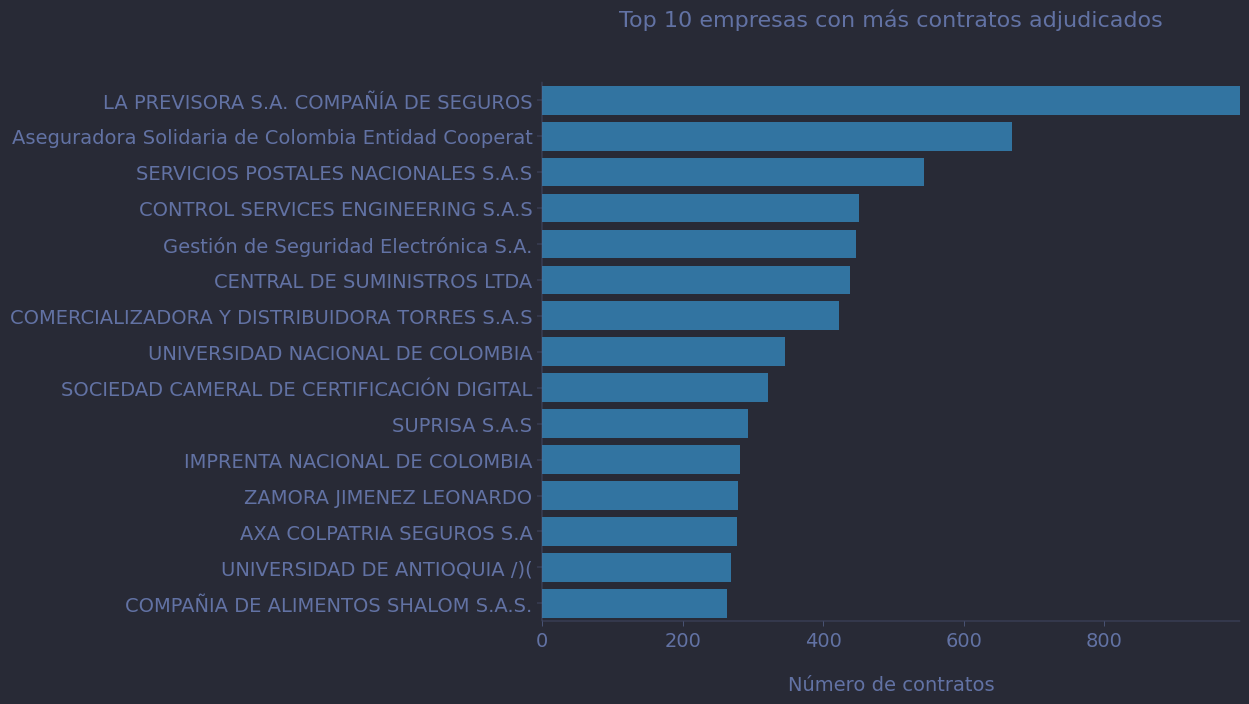

In [ ]:
top_10 = (
    contracts.groupby('Nombre del Proveedor Adjudicado')
    .count().sort_values(by='Entidad', ascending=False)['Entidad'].head(15)
)

with plt.style.context(matplotx.styles.duftify(matplotx.styles.dracula)):
    plt.figure(figsize=(9, 7))
    sns.barplot(y=top_10.index, x= top_10.values, 
                color=palette[0])
    plt.xlabel('Número de contratos')
    plt.ylabel('')
    plt.title('Top 10 empresas con más contratos adjudicados', fontdict={'fontsize': 16})
    sns.despine()
    plt.show()

Número de contratos por cada tipo

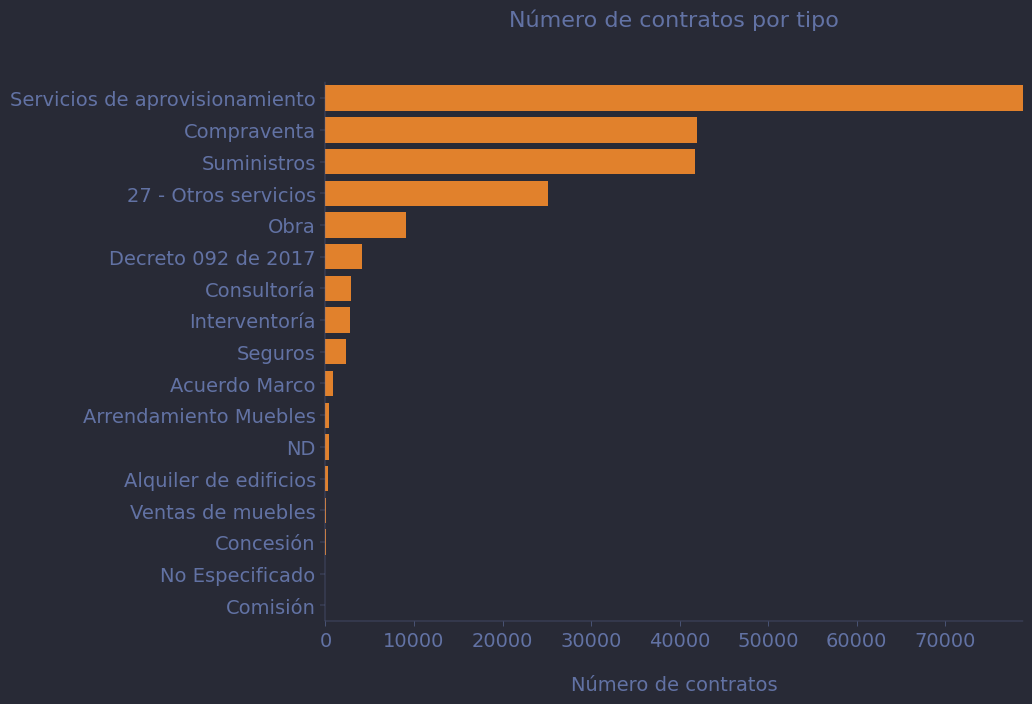

In [ ]:
tipo_contrato = contracts['Tipo de Contrato'].value_counts()

with plt.style.context(matplotx.styles.duftify(matplotx.styles.dracula)):
    plt.figure(figsize=(9, 7))
    sns.barplot(y=tipo_contrato.index, x=tipo_contrato.values, 
                order=tipo_contrato.index, color=palette[1])
    plt.xlabel('Número de contratos')
    plt.ylabel('')
    plt.title('Número de contratos por tipo', fontdict={'fontsize': 16})
    sns.despine()
    plt.legend([])
    plt.grid(False)
    plt.show()

Evolución de las distribución de tipología de contratos

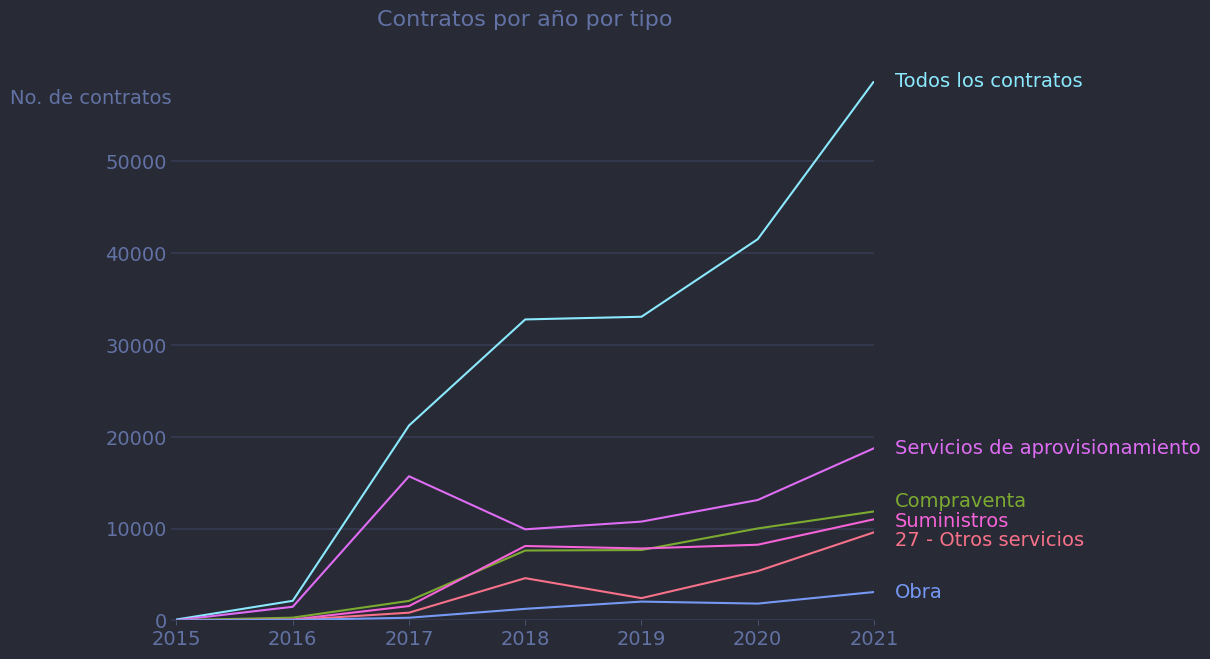

In [ ]:
contracts_year = (
    contracts.groupby(contracts['Fecha de Publicacion del Proceso']
    .map(lambda x: x.year))
    .size()
).loc[:2021]

contracts['Año de Publicacion'] = contracts['Fecha de Publicacion del Proceso'].dt.year
tipos_year = (
    contracts.groupby(['Año de Publicacion', 'Tipo de Contrato'])
    .size().to_frame().reset_index()
)
tipos_year.columns = ['year', 'type', 'count']
tipos_year = tipos_year.query('year != 2022')

with plt.style.context(matplotx.styles.duftify(matplotx.styles.dracula)):
    plt.figure(figsize=(9, 7))
    sns.lineplot(x=contracts_year.index, y=contracts_year.values, 
                 marker=None, label='Todos los contratos')
    for tipo in list(contracts['Tipo de Contrato'].value_counts().head().index):
        sns.lineplot(data=tipos_year.query("type == @tipo"),
                     x='year', y='count', hue='type',
                     label=tipo)
    plt.title('Contratos por año por tipo', fontdict={'fontsize': 16})
    matplotx.ylabel_top("No. de contratos")
    matplotx.line_labels()
    plt.xlabel('')
    plt.grid(True, axis='y')
    sns.despine(bottom=True, left=True)
    plt.legend([])
    plt.show()

<br>
<br>
<br>

## Preprocesamiento 🧽
---

### Join con códigos UNSPSC
Primero, unimos el dataset de procesos de contratación con el de códigos de bienes y servicios, eso no permitirá saber a que segmento pertenece el bien/servicio que están solicitando.

In [ ]:
unspsc_segmento = (
    unspsc.groupby(["Código Segmento","Nombre Segmento"])
    .size().to_frame().reset_index().drop(0,axis=1)
)

In [ ]:
contracts["Código Segmento"] = contracts["Codigo Principal de Categoria"].str.slice(start=3, stop=5)
contracts = contracts.merge(unspsc_segmento, how='left', on="Código Segmento")

In [ ]:
contracts.drop(columns=['Codigo Principal de Categoria', 
                        'Código Segmento', 
                        'Nit Entidad',
                        'Estado de Apertura del Proceso'],
               inplace=True)

### Reducción de los datasets
Para reducir el costo computacional requerido, solo utilizaremos los datos del top 1000 empresas que más han ganado a contratos y los respectivos procesos en las que han sido oferentes.

In [ ]:
bidders_backup = bidders.copy()
contracts_backup = contracts.copy()

In [ ]:
item_min_ratings = 20
filter_items = bidders_backup['ID Procedimiento'].value_counts() > item_min_ratings
filter_items = filter_items[filter_items].index.tolist()
print(len(filter_items))

4368


In [ ]:
user_min_ratings = 10
user_max_ratings = 15

filter_users = (
    bidders_backup.loc[bidders_backup['ID Procedimiento'].isin(filter_items)]
    ['NIT Proveedor'].value_counts()
)
filter_users = (filter_users >= user_min_ratings) & (filter_users <= user_max_ratings) 
filter_users = filter_users[filter_users].index.tolist()
print(len(filter_users))

938


In [ ]:
filter_valid_mask = (
    (bidders_backup['ID Procedimiento'].isin(filter_items)) &
    (bidders_backup['NIT Proveedor'].isin(filter_users))
)
bidders = bidders_backup.loc[filter_valid_mask].copy()

In [ ]:
filter_items = bidders['ID Procedimiento'].unique().tolist()
valid_items = contracts_backup['ID del Proceso'].isin(filter_items)
contracts = contracts_backup.loc[valid_items].copy()

In [ ]:
bid_ids = list(set(filter_items))
bidders_ids = list(set(filter_users))
print(f"{len(bid_ids)} contracts", f"& {len(bidders_ids)} bidders")

3564 contracts & 938 bidders


### Creación de las matrices

In [ ]:
contracts.rename(
    columns={
       'Entidad': 'entity', 
       'Nit Entidad': 'entity_id', 
       'Departamento Entidad': 'entity_department', 
       'ID del Proceso': 'bid_id', 
       'Nombre del Procedimiento': 'bid_title', 
       'Fecha de Publicacion del Proceso': 'published_at', 
       'Precio Base': 'value',
       'Modalidad de Contratacion': 'bid_modality', 
       'Adjudicado': 'is_awarded',
       'Nombre del Proveedor Adjudicado': 'contractor', 
       'NIT del Proveedor Adjudicado': 'contractor_id', 
       'Codigo Principal de Categoria': 'unspsc',  
       'Estado de Apertura del Proceso': 'bid_status', 
       'Tipo de Contrato': 'bid_type',
       'Código Segmento': 'unspsc_segment_code', 
       'Nombre Segmento': 'unspsc_segment', 
       'Año de Publicacion': 'published_at_year', 
    },
    inplace=True
)

bidders.rename(
    columns={
        'ID Procedimiento': 'bid_id', 
        'NIT Entidad': 'entity_id', 
        'NIT Proveedor': 'contractor_id',
    },
    inplace=True
)

In [ ]:
%%time
def get_rating(row):    
    awarded_mask = np.where(
        (contracts.bid_id == row['bid_id']) &
        (contracts.contractor_id == row['contractor_id'])
    )[0]
    if len(awarded_mask) >= 1:
        row['rating'] = 2
    else:
        row['rating'] = 1
    return row

bidders = bidders.apply(get_rating, axis=1)

CPU times: user 22 s, sys: 82.3 ms, total: 22 s
Wall time: 22.1 s


In [ ]:
if True:
    contracts.to_csv('/work/data/02_intermediate/contracts.csv', index=False)
    bidders.to_csv('/work/data/02_intermediate/bidders.csv', index=False)

In [ ]:
def create_rating_map(interactions: pd.DataFrame, ratings: pd.Series) -> dict:
    """Create dictionary of user-items ratings."""
    rating_map = {}
    for i in range(len(interactions)):
        contractor_id = interactions.iloc[i]['contractor_id']
        bid_id = interactions.iloc[i]['bid_id']
        if contractor_id not in rating_map:
            rating_map[contractor_id] = {}
        if bid_id not in rating_map[contractor_id]:
            rating_map[contractor_id][bid_id] = ratings.iloc[i]
        else:
            continue
    return rating_map

In [ ]:
def create_rating_matrix(ratings_map: dict, template_matrix: pd.DataFrame) -> pd.DataFrame:
    """Create two matrix of ratings and probabilities of user-items interactions."""
    rating_matrix = template_matrix.copy()
    proba_matrix = template_matrix.copy()
    for bidder_id in bidders_ids:
        for bid_id in bid_ids:
            if bidder_id in ratings_map:
                if bid_id in ratings_map[bidder_id]:
                    rating = ratings_map[bidder_id][bid_id]
                    rating_matrix.loc[bidder_id, bid_id] = rating
                    proba_matrix.loc[bidder_id, bid_id]  = 1
    return rating_matrix, proba_matrix

In [ ]:
template_array = np.zeros(shape=(len(bidders_ids), len(bid_ids)),
                          dtype=np.int8)
template_matrix = pd.DataFrame(data=template_array, 
                               columns=bid_ids, 
                               index=bidders_ids, 
                               dtype=np.int8)
print(template_matrix.shape)

(938, 3564)


In [ ]:
%%time
X = bidders[['contractor_id', 'bid_id']].copy()
y = bidders['rating']
rating_map = create_rating_map(X, y)
ratings_matrix, probas_matrix = create_rating_matrix(rating_map, template_matrix)

CPU times: user 10.1 s, sys: 13.7 ms, total: 10.1 s
Wall time: 10.1 s


In [ ]:
if True:
    ratings_matrix.to_csv('/work/data/03_processed/ratings_all.csv', index=True)
    probas_matrix.to_csv('/work/data/03_processed/probas_all.csv', index=True)

### Train test split

In [ ]:
%%time
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
train_indexs_list = []
test_indexs_list = []

train_ratings_list = []
train_probas_list = []
test_ratings_list = []
test_list = []

for fold, (train_index, test_index) in enumerate(kfold.split(X=X, y=y), 1):
    print(f'Starting fold {fold}')
    train_indexs_list.append(train_index)  
    test_indexs_list.append(test_index)
    X_train = bidders.iloc[train_index][['contractor_id', 'bid_id']].copy()
    y_train = bidders.iloc[train_index]['rating']
    X_test = bidders.iloc[test_index][['contractor_id', 'bid_id']].copy()
    y_test = bidders.iloc[test_index]['rating']    
    test = bidders.iloc[test_index][['contractor_id', 'bid_id', 'rating']].copy()

    print('\tMapping...')
    rating_map_train = create_rating_map(X_train, y_train)
    rating_map_test = create_rating_map(X_test, y_test)

    print('\tFilling matrix...')
    rating_matrix_train, proba_matrix_train = create_rating_matrix(
        rating_map_train, template_matrix)
    rating_matrix_test, proba_matrix_test = create_rating_matrix(
        rating_map_test, template_matrix)
    print('\tShape:', proba_matrix_train.shape)

    train_ratings_list.append(rating_matrix_train)
    train_probas_list.append(proba_matrix_train)
    test_ratings_list.append(rating_matrix_test)
    test_list.append(test)

Starting fold 1
	Mapping...
	Filling matrix...
	Shape: (938, 3564)
Starting fold 2
	Mapping...
	Filling matrix...
	Shape: (938, 3564)
Starting fold 3
	Mapping...
	Filling matrix...
	Shape: (938, 3564)
Starting fold 4
	Mapping...
	Filling matrix...
	Shape: (938, 3564)
Starting fold 5
	Mapping...
	Filling matrix...
	Shape: (938, 3564)
CPU times: user 54.1 s, sys: 191 ms, total: 54.3 s
Wall time: 54.3 s


In [ ]:
if True:
    with open('/work/data/03_processed/train_indexs_list.pickle', 'wb') as f:
        pickle.dump(train_indexs_list, f) 
    with open('/work/data/03_processed/test_indexs_list.pickle', 'wb') as f:
        pickle.dump(test_indexs_list, f)

    with open('/work/data/03_processed/train_ratings_list.pickle', 'wb') as f:
        pickle.dump(train_ratings_list, f)
    with open('/work/data/03_processed/train_probas_list.pickle', 'wb') as f:
        pickle.dump(train_probas_list, f) 
    with open('/work/data/03_processed/test_ratings_list.pickle', 'wb') as f:
        pickle.dump(test_ratings_list, f)
    with open('/work/data/03_processed/test_list.pickle', 'wb') as f:
        pickle.dump(test_list, f)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=788609fb-0659-4783-a04c-b2e97d409606' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>